# LSA (Latent semantic analysis) 잠재 의미 분석

In [1]:
doc_ls = ['바나나 사과 포도 포도 짜장면',
         '사과 포도',
         '포도 바나나',
         '짜장면 짬뽕 탕수육',
         '볶음밥 탕수육',
         '짜장면 짬뽕',
         '라면 스시',
         '스시 짜장면',
         '가츠동 스시 소바',
         '된장찌개 김치찌개 김치',
         '김치 된장 짜장면',
         '비빔밥 김치'
         ]

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD # 차원 축소

n_topic = 4

tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(doc_ls)

svd = TruncatedSVD(n_components=n_topic, n_iter=100)

U = svd.fit_transform(tfidf) # 단어벡터
Vt = svd.components_ # 문서벡터

In [3]:
len(doc_ls)

12

In [4]:
U.shape

(12, 4)

In [5]:
Vt.shape # 16 = vocabulary size when n_topic = 3

(4, 16)

In [6]:
# 토픽을 구성하는 단어의 크기
vocab= tfidf_vect.get_feature_names()
print(vocab)
n = 3
for i, topic in enumerate(Vt):
    print("Topic {}:".format(i), [(vocab[i], topic[i].round(3)) for i in topic.argsort()[:-n-1:-1]])

['가츠동', '김치', '김치찌개', '된장', '된장찌개', '라면', '바나나', '볶음밥', '비빔밥', '사과', '소바', '스시', '짜장면', '짬뽕', '탕수육', '포도']
Topic 0: [('포도', 0.583), ('짜장면', 0.499), ('사과', 0.33)]
Topic 1: [('짜장면', 0.44), ('짬뽕', 0.391), ('스시', 0.315)]
Topic 2: [('스시', 0.703), ('라면', 0.353), ('소바', 0.253)]
Topic 3: [('김치', 0.682), ('비빔밥', 0.373), ('된장찌개', 0.272)]


In [7]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def calc_similarity_matrix(vectors):
    def consine_similarity(a,b):
        return dot(a, b)/(norm(a)*norm(b))
    
    n_word = len(vectors)
    similarity_matrix = np.zeros((n_word, n_word))
    
    for i in range(n_word):
        for j in range(n_word):
            similarity_matrix[j, i] = consine_similarity(vectors[i], vectors[j]).round(4)
        
    return similarity_matrix

In [8]:
# 단어 벡터간 코사인유사도를 측정하여 유사도 측정
word_vectors = Vt.T
word_similarity_matrix = calc_similarity_matrix(word_vectors)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_similarity(similarity_matrix, label):
    mask =np.triu(np.ones_like(similarity_matrix, dtype=np.bool))
    plt.rcParams['figure.figsize'] = [8, 6]
    plt.rc('font', family='Malgun Gothic')
    ax = sns.heatmap(similarity_matrix, mask=mask, xticklabels=label, yticklabels=label,
                     annot=True, fmt=".2f", annot_kws={"size":8},cmap="coolwarm")

C:\Users\andyj\anaconda3\envs\abangues\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
C:\Users\andyj\anaconda3\envs\abangues\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\andyj\anaconda3\envs\abangues\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


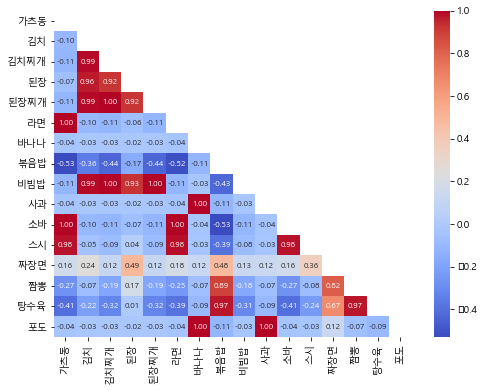

In [10]:
# 단어와 단어의 유사도
visualize_similarity(word_similarity_matrix, vocab)

In [11]:
U.shape

(12, 4)

C:\Users\andyj\anaconda3\envs\abangues\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


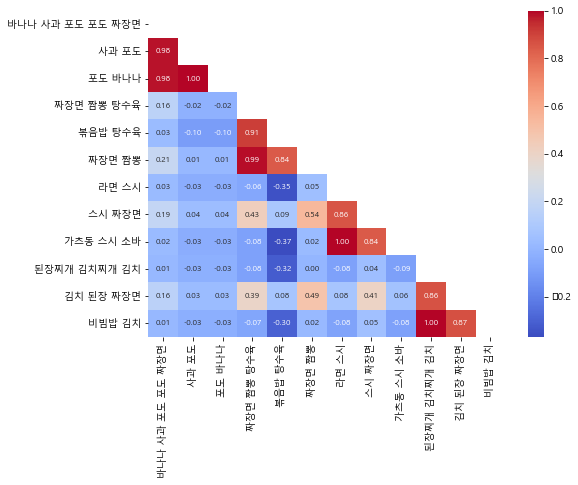

In [12]:
# 문서와 문서의 유사도
doc_similarity_matrix = calc_similarity_matrix(U)
visualize_similarity(doc_similarity_matrix, doc_ls)

In [13]:
def visualize_vectors(vectors, labels):
    tsne = TSNE(n_components=2, n_iter=10000, perplexity=2)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(vectors)

    plt.figure(figsize=(10, 6))
    plt.scatter(T[:,0], T[:, 1], c='orange', edgecolors='r')
    for label, x, y in zip(labels, T[:,0], T[:, 1]):
        plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

# LDA (Latent Dirichlet Allocation) 잠재 디리클레 할당

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andyj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
import enum
import random
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, porter
from nltk.corpus import stopwords
from collections import defaultdict

topic_indices = [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0]

doc_ls = ["Cute kitty", 
"Eat rice or cake", 
"Kitty and hamster",
"Eat bread", 
"Rice, bread and cake", 
"Cute hamster eats bread and cake"]

In [16]:
class LDA:

    def __init__(self, docs, topic_num, alpha=0.1, beta=0.001):
        self.alpha = alpha
        self.beta = beta
        self.k = topic_num
        self.docs = docs

    #LDA 계산 철자 step 1 
    def randomly_analysis_topic (self):
        dic = defaultdict()
        t2i = defaultdict(lambda: len(t2i))
        i2t = defaultdict()
        
        # porter.stem() -> lemmetization
        porter = PorterStemmer()
        stopword = stopwords.words('english')
        stopword.append(',')
        index = 0
        for d, tokens in enumerate([word_tokenize(doc) for doc in self.docs]):
            for w, token in enumerate([porter.stem(token.lower()) for token in tokens if token not in stopword]):
                i2t[t2i[token]]= token
                dic[(d, t2i[token], w)] = topic_indices[index]
                # dic[(d, t2i[token], w)] = random.randint(0, self.k -1)
                index += 1
#        for doc in self.docs:
#             for token in word_tokenize(doc):
#                 i2t[t2i[token]] = token                

        return dic, t2i, i2t

    
    #LDA 계산 철자 step 2
    def count_doc_topic(self, term_topic, t2i):
        docs = np.zeros((self.k, len(self.docs)))
        terms = np.zeros((self.k, len(t2i)))

        docs.fill(self.alpha)
        terms.fill(self.beta)

        for (d, n, w) in term_topic.keys():
            topic = term_topic[(d, n, w)]
            docs[topic, d] += 1
            terms[topic, n] += 1

        print(docs)
        print(terms)

        return docs, terms



    def iterate_assign_topic(self, term_topic, docs, terms, i2t):
        prev = {}

        while prev != term_topic:
            for (d, n, w) in term_topic:
                topic = [0, 0]

                docs[term_topic[(d, n, w)], d] -= 1
                terms[term_topic[(d, n, w)], n] -= 1

                prev = term_topic

                for t in range(self.k):
                    p_t_d = docs[t, d] /docs[:, d].sum() # 문서내에 토픽이 있을 확률
                    p_w_t = terms[t, n] / terms[t, :].sum() # 토픽의 단어가 ** 일 확률
                    prob = p_t_d * p_w_t # 문서 안에 **가 토픽일 확률

                    if topic[1] < prob:
                        topic = [t, prob]


                term_topic[(d, n, w)] = topic[0]
                docs[topic[0], d] += 1
                terms[topic[0], n] += 1

        return terms

 # LDA 계산 절차 step 3  
    def topic_modeling(self, count=3):
        term_topic, t2i, i2t = self.randomly_analysis_topic()
        docs, terms  = self.count_doc_topic(term_topic, t2i)
        terms = self.iterate_assign_topic(term_topic, docs, terms, i2t)

        score = terms / terms.sum(axis=1, keepdims=True)

        for i in range(self.k):
            print(f"topic {i} =>", end=" ")
            sorted_index = np.flip(np.argsort(score[i]), 0)[:count]
            for j in sorted_index:
                print("({}, {})".format(i2t[j], score[i, j].round(3)), end=" ")

            print("")

In [17]:
lda = LDA(doc_ls, 2)
lda.topic_modeling(3)

[[1.1 2.1 0.1 2.1 2.1 2.1]
 [1.1 1.1 2.1 0.1 1.1 3.1]]
[[1.001e+00 1.000e-03 2.001e+00 1.001e+00 3.001e+00 1.000e-03 2.001e+00]
 [1.001e+00 2.001e+00 1.001e+00 1.001e+00 1.000e-03 2.001e+00 1.001e+00]]
topic 0 => (bread, 0.273) (cake, 0.273) (eat, 0.273) 
topic 1 => (hamster, 0.333) (kitti, 0.333) (cute, 0.333) 


In [ ]:
!pip install pyLDAvis

In [18]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True, random_state=42, remove=('header', 'footer', 'quotes'))

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

In [20]:
import spacy
nlp = spacy.load('en_core_web_sm')

C:\Users\andyj\anaconda3\envs\abangues\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\andyj\anaconda3\envs\abangues\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\andyj\anaconda3\envs\abangues\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\andyj\anaconda3\envs\abangues\lib\site-packages\tensorf

In [21]:
print(dataset.data[0])
doc = nlp(dataset.data[0])
result = " ".join([token.lemma_ for token in doc if token.is_stop==False and token.tag_ == 'N'])
print('*'*30)
print(result)
# for token in doc:
#     print(token.text, token.tag_, token.pos_, token.is_stop, )

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





******************************



In [22]:
def cleansing(text):
    result = ""
    if text:
        doc = nlp(text)
        result = " ".join([token.text for token in doc if token.is_stop==False and token.tag_[0] in ['N', 'V'] ])
        return result

    return result

In [23]:
import pandas as pd

news_df = pd.DataFrame({'document':dataset.data})
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: " ".join([w.lower() for w in x.split() if len(w) > 3]))
news_df['clean_doc'] = news_df['clean_doc'].apply(cleansing)

C:\Users\andyj\anaconda3\envs\abangues\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [24]:
def my_tokenizer(text):
    return text.split()

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

tfidf_vect = TfidfVectorizer(tokenizer=my_tokenizer)
tfidf = tfidf_vect.fit_transform(news_df['clean_doc'])
lda = LatentDirichletAllocation(n_components=20, max_iter=20, learning_method='online', random_state=42)
lda_output = lda.fit_transform(tfidf)

In [26]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda, tfidf, tfidf_vect, mds='tsne')
pyLDAvis.display(vis)

C:\Users\andyj\anaconda3\envs\abangues\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\Users\andyj\anaconda3\envs\abangues\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\andyj\anaconda3\envs\abangues\lib\site-packages\sklearn\manifold\_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify 

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer


def tuning_hyperparams(train_data, n_jobs=1) :                
    lda_pipeline = Pipeline([('tfidf_vect', TfidfVectorizer(tokenizer = my_tokenizer)),
                              ('lda', LatentDirichletAllocation(max_iter=10, random_state=100))])
    search_params = {'tfidf_vect__ngram_range': [(1, 1), (1, 2)],
                    'lda__n_components': [5, 10, 20]}
    gs_lda = GridSearchCV(lda_pipeline, search_params, n_jobs=n_jobs)
    gs_lda = gs_lda.fit(train_data)
    print("Best score: {0}".format(gs_lda.best_score_))  
    print("Best parameters set:")  
    best_parameters = gs_lda.best_estimator_.get_params()  
    for param_name in sorted(list(best_parameters.keys())):  
        print("\t{0}: {1}".format(param_name, best_parameters[param_name]))
    return gs_lda.best_estimator_
lda_pipeline = tuning_hyperparams(news_df['clean_doc'])

C:\Users\andyj\anaconda3\envs\abangues\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\andyj\anaconda3\envs\abangues\lib\site-packages\sklearn\model_selection\_split.py:443: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_sampl

Best score: -159545.35614649745
Best parameters set:
	lda: LatentDirichletAllocation(n_components=5, random_state=100)
	lda__batch_size: 128
	lda__doc_topic_prior: None
	lda__evaluate_every: -1
	lda__learning_decay: 0.7
	lda__learning_method: batch
	lda__learning_offset: 10.0
	lda__max_doc_update_iter: 100
	lda__max_iter: 10
	lda__mean_change_tol: 0.001
	lda__n_components: 5
	lda__n_jobs: None
	lda__perp_tol: 0.1
	lda__random_state: 100
	lda__topic_word_prior: None
	lda__total_samples: 1000000.0
	lda__verbose: 0
	memory: None
	steps: [('tfidf_vect', TfidfVectorizer(tokenizer=<function my_tokenizer at 0x000001D4A8442AF8>)), ('lda', LatentDirichletAllocation(n_components=5, random_state=100))]
	tfidf_vect: TfidfVectorizer(tokenizer=<function my_tokenizer at 0x000001D4A8442AF8>)
	tfidf_vect__analyzer: word
	tfidf_vect__binary: False
	tfidf_vect__decode_error: strict
	tfidf_vect__dtype: <class 'numpy.float64'>
	tfidf_vect__encoding: utf-8
	tfidf_vect__input: content
	tfidf_vect__lowercase:

In [28]:
tfidf_vect = lda_pipeline.named_steps['tfidf_vect']
tfidf = tfidf_vect.fit_transform(news_df['clean_doc'])
lda = lda_pipeline.named_steps['lda']
vis = pyLDAvis.sklearn.prepare(lda, tfidf, tfidf_vect, mds='tsne')
pyLDAvis.display(vis)

C:\Users\andyj\anaconda3\envs\abangues\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\andyj\anaconda3\envs\abangues\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\Users\andyj\anaconda3\envs\abangues\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated 